# Multipole model exploration

In [28]:
import h5py
import os
import numpy as np
from tqdm import tqdm

data_dir = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

data = []
files = os.listdir(data_dir)

with h5py.File(os.path.join(data_dir, files[0])) as f20:
    with h5py.File(os.path.join(data_dir, files[0])) as f21:
        with h5py.File(os.path.join(data_dir, files[0])) as f2n2:
            with h5py.File(os.path.join(data_dir, files[0])) as f22:
                with h5py.File(os.path.join(data_dir, files[0])) as f2n1:

                    for w20, w21, w2n2, w22, w2n1 in tqdm(zip(f20["waveforms"][:], f21["waveforms"][:], f2n2["waveforms"][:], f22["waveforms"][:], f2n1["waveforms"][:]), total = 100000):
                        data.append([w22, w21, w20, w2n1, w2n2])

data = np.array(data)
data.shape

bbh_q20_data.hdf5
bbh_q21_data.hdf5
bbh_q2n2_data.hdf5
bbh_q22_data.hdf5
bbh_q2n1_data.hdf5


In [14]:
import keras
from keras import layers
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

inp = keras.Input((5, 2048))

x = layers.Reshape((1, 5, 2048))(inp)
x = layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 3), activation = "leaky_relu", kernel_initializer = "glorot_uniform", data_format = "channels_first")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)
x = layers.Dense(512, activation = 'leaky_relu', kernel_initializer = "glorot_uniform")(x)

enc = layers.Dense(10)(x)

y = layers.Dense(5*2048, activation="leaky_relu", kernel_initializer = "glorot_uniform")(enc)
opt = layers.Reshape((5, 2048))(y)

multimode_autoencoder = keras.Model(inp, opt)

multimode_autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 2048)]         0         
                                                                 
 reshape_8 (Reshape)         (None, 1, 5, 2048)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 1, 682)        1664      
                                                                 
 flatten_8 (Flatten)         (None, 43648)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               22348288  
                                                                 
 dense_22 (Dense)            (None, 10)                5130      
                                                                 
 dense_23 (Dense)            (None, 10240)             1126

In [30]:
multimode_autoencoder.compile(optimizer = 'adam', loss = 'mae')

multimode_autoencoder.fit(data[:10000], data[:10000], epochs = 200, batch_size = 50)

2024-05-23 18:17:48.836537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.48G (4809359360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 18:17:48.838836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.03G (4328423424 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 1/200
200/200 [==============================] - 4s 12ms/step - loss: 0.0141
Epoch 2/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0077
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 0.0064
Epoch 4/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 5/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0054
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0052
Epoch 7/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0050
Epoch 8/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0047
Epoch 9/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0045
Epoch 10/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0043
Epoch 11/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0040
Epoch 12/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0038
E

4/4 [==============================] - 0s 14ms/step


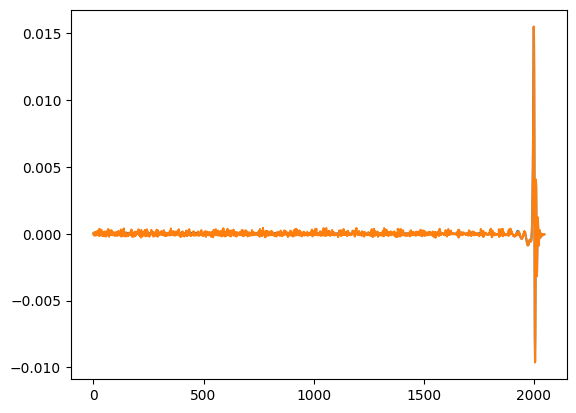

In [26]:
import matplotlib.pyplot as plt

ae_data = multimode_autoencoder.predict(data[:1000], batch_size=256)

plt.plot(data[0, 2])
plt.plot(ae_data[0, 2])

# Model evaluation

In [1]:
import tensorflow as tf
from utils.eval import load_model_and_data_loader
from utils.config import process_config
from utils.plot_utils import *
from data_loader.gw_dataloader import GWDataLoader
import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_dir = "/home/nino/GW/Keras-Project-Template/experiments/multipole_q_reg/full_model.hdf5"
config_path = "/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/config.json"
data_folder = "/home/nino/GW/Keras-Project-Template/data/q_multipole"

config, _ = process_config(config_path)
model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints")

def define_model(base_model):

    nozz_22 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))
    nozz_21 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_20 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-3].input, base_model.layers[-1].layers[-1].output))
    nozz_2n1 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-2].input, base_model.layers[-1].layers[-1].output))
    nozz_2n2 = keras.models.clone_model(keras.Model(base_model.layers[-1].layers[-1].input, base_model.layers[-1].layers[-1].output))

    inp = base_model.layers[1].input

    x = base_model.layers[1](inp)
    x = base_model.layers[2](x)

    for layer in base_model.layers[3].layers[:-4]:
        x = layer(x)

    mp20 = base_model.layers[3].layers[-4](x)
    mp21 = base_model.layers[3].layers[-3](mp20)
    mp22 = base_model.layers[3].layers[-2](mp21)

    opt_22 = nozz_22(mp22)
    opt_2n2 = nozz_2n2(mp22)
    opt_21 = nozz_21(mp21)
    opt_2n1 = nozz_2n1(mp21)
    opt_20 = nozz_20(mp20)
    
    return keras.Model(inp, [opt_20, opt_21, opt_2n1, opt_22, opt_2n2])

2024-05-24 16:14:53.153270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:14:53.342630: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 16:14:54.418191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-24 16:14:54.418307: W tensorflow/co

2024-05-24 16:15:34.250728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:15:35.328889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3174 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/q_bbh_reg_light/reg_q_bbh_light/checkpoints/best_model.hdf5 ...

Model loaded


In [4]:
multimode_model = define_model(model)
multimode_model.load_weights(model_dir)
test_wv = multimode_model.predict(np.array([[1.7, 1.3], [2.5, 1.7]]))

1/1 [==============================] - 0s 225ms/step


In [16]:
np.max(test_wv[0][0])

0.07861644

In [11]:
multimode_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 10)           6666        ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 10)           536074      ['model_1[2][0]']                
                                                                                                  
 input_4 (InputLayer)           multiple             0           ['model[2][0]']                  
                                                                                           

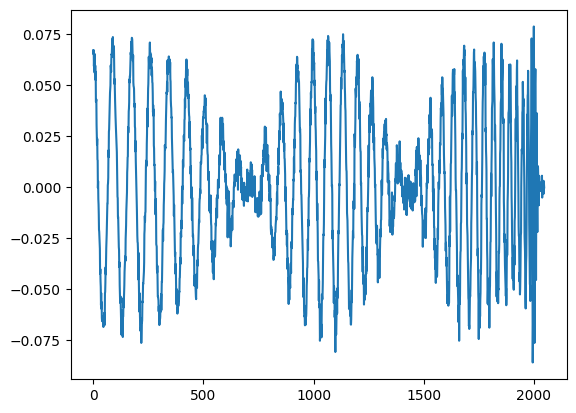

In [9]:
import matplotlib.pyplot as plt

_=plt.plot(test_wv[0][0])

# Keras' overlap loss function

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-28 13:03:22.536166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:03:22.712071: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 13:03:23.663810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-05-28 13:03:23.663896: W tensorflow/co

In [6]:
data_loader.__dir__()

['config',
 'train_weights',
 'delta_t',
 'X_train',
 'y_train',
 'X_test',
 'y_test',
 'X',
 'y',
 'in_out_shapes',
 '__module__',
 '__doc__',
 '__init__',
 'get_train_data',
 'get_test_data',
 'get_data',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [2]:
from tensorflow.signal import rfft
from keras.losses import mean_absolute_error
import keras.backend as K

def overlap(h1, h2, dt=2*4.925794970773135e-06, df=None):

    split_size = int(4096/2)

    h1_amp, h1_phs = h1[:, :split_size], h1[:, split_size:]
    h2_amp, h2_phs = h2[:, :split_size], h2[:, split_size:]

    h1 =  tf.cast(h1_amp, tf.complex64)*tf.math.exp(1j*(tf.cast(h1_phs, tf.complex64)))
    h2 = tf.cast(h2_amp, tf.complex64)*tf.math.exp(1j*(tf.cast(h2_phs, tf.complex64)))

    h1_f = tf.signal.fft(h1)*dt
    h2_f = tf.signal.fft(h2)*dt
    
    df = 1.0 /  2048 / dt
    sig_norm = 4*df

    sig1 = K.sqrt(tf.cast((tf.math.reduce_sum(tf.math.conj(h1_f)*h1_f,axis=-1)),tf.float32)*sig_norm)
    sig2 = K.sqrt(tf.cast((tf.math.reduce_sum(tf.math.conj(h2_f)*h2_f,axis=-1)),tf.float32)*sig_norm)
    
    norm = 1/sig1/sig2
    inner = tf.cast(tf.math.reduce_sum((tf.math.conj(h1_f)*h2_f),axis=-1),tf.float32)
    overl = tf.cast((4*df*inner*norm),tf.float32)
    
    return  K.abs(1. - overl)

def ovlp_mae_loss(y_pred, y_true):
    
    return overlap(y_pred, y_true) + mean_absolute_error(y_pred, y_true)

In [3]:
import keras
from keras import layers
import h5py
import numpy as np
from data_loader.gw_dataloader import GWDataLoader
from utils.config import get_config_from_json

config, _ = get_config_from_json("/home/nino/GW/Keras-Project-Template/configs/gw_reg_ae_config.json")
config.data_loader.data_output_type = "amplitude_phase"
data_loader =  GWDataLoader(config)

inp = keras.Input(data_loader.in_out_shapes['input_shape'])
x = layers.Dense(1024, activation='leaky_relu')(inp)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
opt = layers.Dense(data_loader.in_out_shapes['output_shape'])(x)

model = keras.Model(inp, opt)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-6), metrics = [overlap, mean_absolute_error], loss = ovlp_mae_loss)

2024-05-28 13:03:49.966366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:03:51.123349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9884 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [4]:
model.fit(data_loader.get_train_data() , validation_data = data_loader.get_test_data(), epochs = 300, batch_size = 64)

Epoch 1/300
1639/1639 [==============================] - 15s 7ms/step - loss: 44.4915 - overlap: 0.8435 - mean_absolute_error: 43.6479 - val_loss: 44.4179 - val_overlap: 0.7703 - val_mean_absolute_error: 43.6476
Epoch 2/300
1639/1639 [==============================] - 11s 7ms/step - loss: 44.3873 - overlap: 0.7425 - mean_absolute_error: 43.6447 - val_loss: 44.3640 - val_overlap: 0.7194 - val_mean_absolute_error: 43.6446
Epoch 3/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.3455 - overlap: 0.7046 - mean_absolute_error: 43.6410 - val_loss: 44.3317 - val_overlap: 0.6919 - val_mean_absolute_error: 43.6398
Epoch 4/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.3150 - overlap: 0.6804 - mean_absolute_error: 43.6346 - val_loss: 44.3003 - val_overlap: 0.6687 - val_mean_absolute_error: 43.6317
Epoch 5/300
1639/1639 [==============================] - 17s 10ms/step - loss: 44.2812 - overlap: 0.6575 - mean_absolute_error: 43.6237 - val_loss: 44

KeyboardInterrupt: 

20/20 [==============================] - 0s 4ms/step


Calculating mismatches: 100%|██████████| 10000/10000 [02:12<00:00, 75.20it/s]
/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


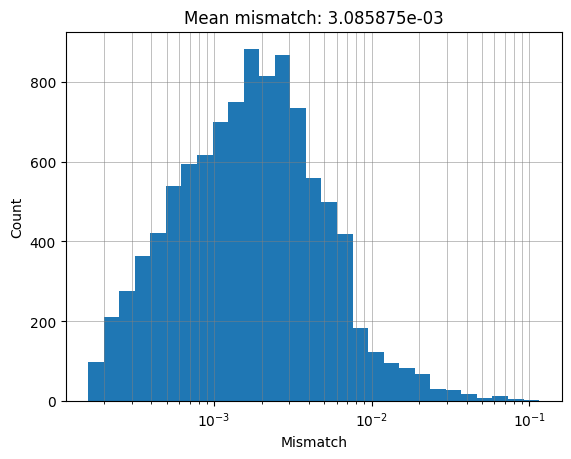

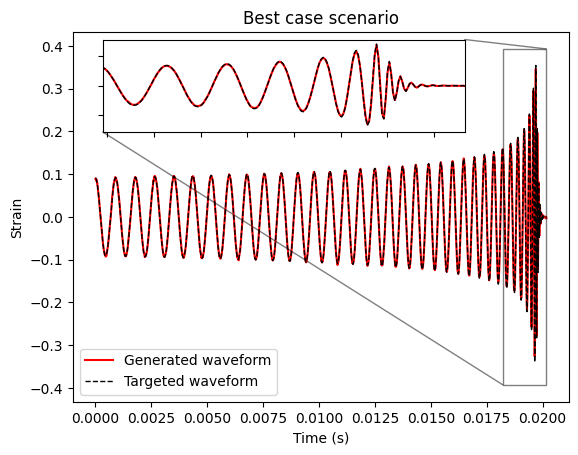

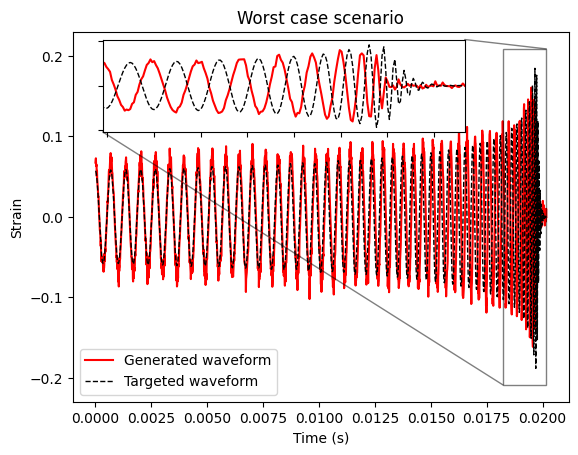

In [8]:
from utils.plot_utils import nb_evaluate_model
import numpy as np

y_pred = model.predict(data_loader.X_test, batch_size = 1024)
y = []
grd = []

for wv, grd_wv in zip(y_pred, data_loader.y_test):
    amp = wv[:2048]
    phs = wv[2048:]

    grd_amp = grd_wv[:2048]
    grd_phs = grd_wv[2048:]

    grd.append(grd_amp*np.exp(1.0j*grd_phs))
    y.append(amp*np.exp(1.0j*phs))

y_pred = np.array(y)
y_true = np.array(grd)

nb_evaluate_model(y_pred[:10000], y_true[:10000], data_loader.delta_t)


In [2]:
from utils.eval import load_model_and_data_loader

model, data_loader = load_model_and_data_loader("/home/nino/GW/Keras-Project-Template/experiments/osv_qz_ovlp_light/reg_q_bbh_light/checkpoints")

/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-05-28 11:26:21.552789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:26:22.739306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8820 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Loading model checkpoint /home/nino/GW/Keras-Project-Template/experiments/osv_qz_ovlp_light/reg_q_bbh_light/checkpoints/best_model.hdf5 ...



ValueError: Weight count mismatch for layer #0 (named model_1 in the current model, model_1 in the save file). Layer expects 6 weight(s). Received 4 saved weight(s)

In [9]:
y_pred = model.predict(data_loader.X_test, batch_size = 1024)

mae_ts = mean_absolute_error(y_pred, data_loader.y_test)
ovlp_ts = overlap(y_pred, data_loader.y_test)

20/20 [==============================] - 0s 2ms/step


In [16]:
print(f"Mean abs error:   {np.mean(mae_ts.numpy()):.4f}\nMean 1 - Overlap: {np.mean(ovlp_ts.numpy()):.4f}")

Mean abs error:   0.0204
Mean 1 - Overlap: 0.6946


In [ ]:
import keras.optimizers
from keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss = 'mae', metrics = [overlap])
callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15)]

model.fit(data_loader.get_generator_train_data(), validation_data=data_loader.get_generator_test_data(), epochs = 1000, batch_size = 50, callbacks=callbacks)

20/20 [==============================] - 0s 2ms/step


Calculating mismatches: 100%|██████████| 1000/1000 [00:13<00:00, 73.41it/s]


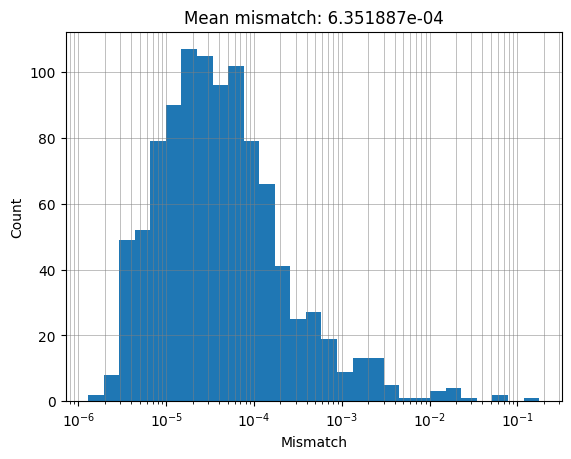

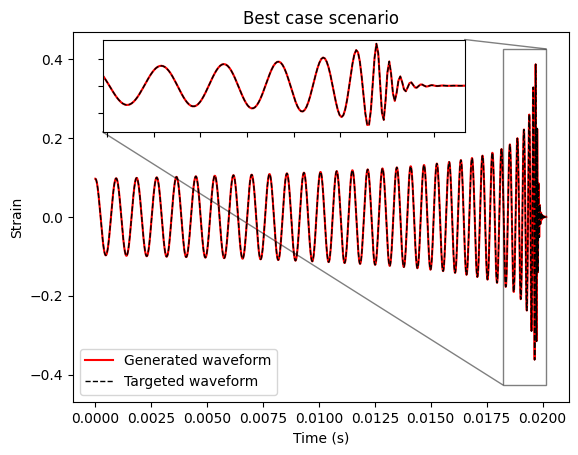

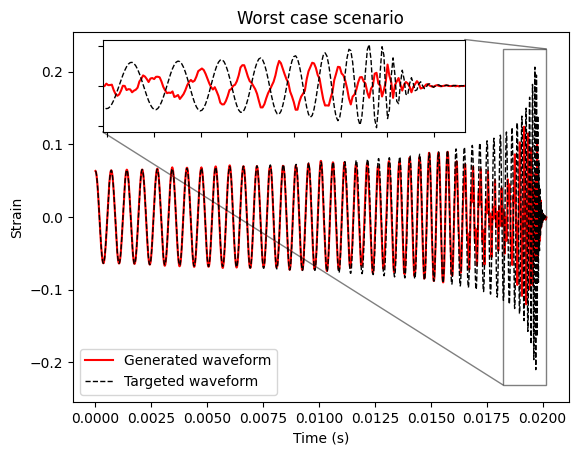

In [27]:
from utils.plot_utils import nb_evaluate_model

y_pred_ts = model.predict(data_loader.X_test, batch_size=1024)

nb_evaluate_model(y_pred_ts, data_loader, data_loader.delta_t)